In [1]:
import numpy  as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
RAND_SEED=1

In [4]:
data_speed=pd.read_csv('./data/phase/background0_phase.csv')['phase']

      phase speed     phase
Mean    -0.000002 -6.359112
Std      0.008713  2.486367
Var      0.000076  6.182020


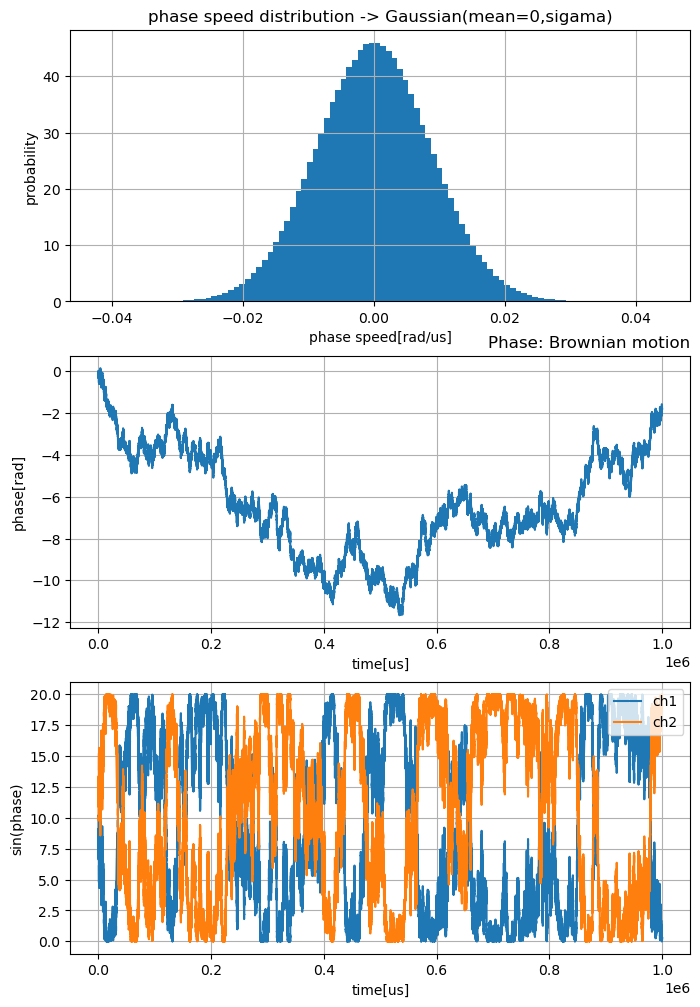

In [167]:
GAMMY=1.0

def get_sig_from_speed(phase_speed,channel):
    phase=np.cumsum(phase_speed)
    #phase*=np.pi/180
    if channel==1:
        return SIG_AMP*(GAMMY+np.sin(phase))
    elif channel==2:
        return SIG_AMP*(GAMMY-np.sin(phase))
def get_sig_from_phase(phase,channel):
    #phase*=np.pi/180
    if channel==1:
        return SIG_AMP*(GAMMY+np.sin(phase))
    elif channel==2:
        return SIG_AMP*(GAMMY-np.sin(phase))

PHASE_SEEPD=0.5/180*np.pi #rad/us
SIG_AMP=10 # 10sample/us  cps=10M
time_axis=np.arange(0,1e6,1) #1us分辨率，len=1s  SR=1M
rng=np.random.default_rng(RAND_SEED)
phase_speed=rng.normal(0,PHASE_SEEPD,time_axis.shape)
phase_speed[0]=0
phase=np.cumsum(phase_speed)
sig_ch1=get_sig_from_speed(phase_speed,1)
sig_ch2=get_sig_from_speed(phase_speed,2)
plt.figure(figsize=(8,12))
plt.subplot(3,1,1)
plt.hist(phase_speed,bins=100,density=True)
plt.ylabel('probability')
plt.xlabel('phase speed[rad/us]')
plt.title('phase speed distribution -> Gaussian(mean=0,sigama)')
plt.grid()
plt.subplot(3,1,2)
plt.plot(time_axis,phase)
plt.xlabel('time[us]')
plt.ylabel('phase[rad]')
plt.title('Phase: Brownian motion',loc='right')
plt.grid()
plt.subplot(3,1,3)
plt.plot(time_axis,sig_ch1,label='ch1')
plt.plot(time_axis,sig_ch2,label='ch2')
plt.xlabel('time[us]')
plt.ylabel('sin(phase)')
plt.grid()
plt.legend(loc=1)
#plt.xlim(0,100000)

df=pd.DataFrame({'Mean':phase_speed.mean(),'Std':phase_speed.std(),'Var':phase_speed.var()},index=['phase speed']).T
def push_data(data,name):
    df[name]=[data.mean(),data.std(),data.var()]
    print(df)
push_data(phase,'phase')

In [168]:
def get_phase_from_count(ch1,ch2):
    if ch1+ch2==0:
        return 0
    else:
        return np.arcsin((ch1-ch2)/(ch1+ch2))

def measure_count(sig,method):
    """method=0:测量返回测量时间内最后一个时刻的phase;  
    method=1:测量时间内的phase的积分;  
    method=2:测量时间内的phase的积分，并引入shot noise;"""
    if method==0:
        return sig[-1]
    elif method==1:
        return sig.sum()
    elif method==2:
        return rng.poisson(sig.sum())
    

time_exposure=100 #us
sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
phase_speed_M1=np.copy(phase_speed.reshape((-1,time_exposure)))
phase_M1=np.zeros_like(phase_speed_M1)
phase_measure_M1=np.zeros(phase_speed_M1.shape[0]) # 测量出的反馈量
rng=np.random.default_rng(RAND_SEED)
phase_offest=0
for i in tqdm(range(sig_ch1_exposure.shape[0])):
    phase_M1[i]=np.cumsum(phase_speed_M1[i])+phase_offest
    sig_ch1_exposure[i]=get_sig_from_phase(phase_M1[i],1)
    sig_ch2_exposure[i]=get_sig_from_phase(phase_M1[i],2)
    ###引入shot noise
    ch1_measure=measure_count(sig_ch1_exposure[i],2)#rng.poisson(sig_ch1_exposure[i].sum())#+rng.poisson(1)-1  # shot noise 应该于计数有关
    ch2_measure=measure_count(sig_ch2_exposure[i],2)#rng.poisson(sig_ch2_exposure[i].sum())#+rng.poisson(1)-1
    phase_measure_M1[i]=get_phase_from_count(ch1_measure,ch2_measure)
    #phase_measure_M1[i]=phase_M1[i,-1]
    
    ##---反馈
    if i<(sig_ch1_exposure.shape[0]-1):
        phase_speed_M1[i+1,0]-=phase_measure_M1[i]#fb_weight(phase_measure_M1[i],time_exposure) # 反馈到下一个exposure

    phase_offest=phase_M1[i,-1]
phase_out_M1=np.cumsum(phase_speed_M1.reshape(-1))
push_data(phase_out_M1,'phase M1')

100%|██████████| 10000/10000 [00:00<00:00, 16340.60it/s]


      phase speed     phase  phase M1
Mean    -0.000002 -6.359112 -0.000198
Std      0.008713  2.486367  0.083214
Var      0.000076  6.182020  0.006925


### 改变权重

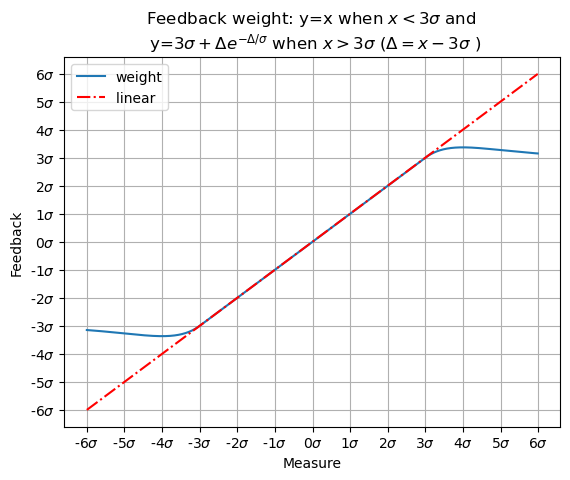

In [169]:
def fb_weight(measure, time_exposure,sigma=1,denominator=1):
    """denominator=1: 越大，权重越陡峭"""
    phase_speed_in_measure=np.sqrt(time_exposure)*PHASE_SEEPD #sigma
    threshold=sigma*phase_speed_in_measure #3 sigma
    weight=lambda x: np.sign(x) *(threshold + (np.abs(x) - threshold)*np.exp(- (np.abs(x) - threshold)/phase_speed_in_measure/denominator))
    #weight=lambda x: np.sign(x) *(-(np.abs(x)/threshold-2)**2+2)*threshold
    mask = np.abs(measure) > threshold
    measure_filtered = np.where(mask, weight(measure),measure)
    #split=0.314*phase_speed_in_measure
    #measure_filtered = np.where(np.abs(measure)<split, 0, measure_filtered)
    
    return measure_filtered

phase_speed_in_measure=np.sqrt(time_exposure)*PHASE_SEEPD #sigma
x=np.arange(-2,2,1/256)*3*phase_speed_in_measure
plt.plot(x,fb_weight(x,time_exposure=time_exposure,sigma=3),label='weight')
plt.plot(x,x,'r-.',label='linear ')
plt.legend()
plt.grid()
plt.xticks(np.arange(-6,7,1)*1*phase_speed_in_measure,['{}$\sigma$'.format(i*1) for i in np.arange(-6,7,1)])
plt.yticks(np.arange(-6,7,1)*1*phase_speed_in_measure,['{}$\sigma$'.format(i*1) for i in np.arange(-6,7,1)])
plt.xlabel('Measure')
plt.ylabel('Feedback')
plt.title('Feedback weight: y=x when $x<3\sigma$ and \n y=3$\sigma+\Delta e^{-\Delta/\sigma}$ when $x>3\sigma$ ($\Delta =x-3\sigma$ )')
plt.show()

In [173]:
time_exposure=2 #us
time_inter=2
dirc_inter=10
sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
phase_speed_M4=np.copy(phase_speed.reshape((-1,time_exposure)))
phase_M4=np.zeros_like(phase_speed_M4)
sig_ch1_measure_M4=np.zeros(phase_speed_M4.shape[0]) # 测量量ch1
sig_ch2_measure_M4=np.zeros(phase_speed_M4.shape[0]) # 测量量ch2
phase_measure_M4=np.zeros(phase_speed_M4.shape[0]) # 测量量
phase_fb_inter_M4=np.nan*np.zeros(phase_speed_M4.shape[0]) # 积分反馈量
phase_fb_dirc_M4=np.nan*np.zeros(phase_speed_M4.shape[0]) # 方向反馈量
phase_fb_M4=np.zeros(phase_speed_M4.shape[0]) # 反馈量
rng=np.random.default_rng(RAND_SEED)
phase_offest=0
fb0=0
sigma=1
for i in tqdm(range(sig_ch1_exposure.shape[0])):
    phase_M4[i]=np.cumsum(phase_speed_M4[i])+phase_offest
    sig_ch1_exposure[i]=get_sig_from_phase(phase_M4[i],1)
    sig_ch2_exposure[i]=get_sig_from_phase(phase_M4[i],2)
    ch1_measure=rng.poisson(sig_ch1_exposure[i].sum())
    ch2_measure=rng.poisson(sig_ch2_exposure[i].sum())
    sig_ch1_measure_M4[i]=ch1_measure
    sig_ch2_measure_M4[i]=ch2_measure
    phase_measure_M4[i]=get_phase_from_count(ch1_measure,ch2_measure)
    #c0=get_phase_from_count(sig_ch1_exposure[i,-1],sig_ch2_exposure[i,-1])
    c0=phase_measure_M4[i]
    
    phase_fb_M4[i]=fb_weight(c0,time_exposure=time_exposure,sigma=0.7)
    


    ##-- 反馈 
    if i<(sig_ch1_exposure.shape[0]-1):
        phase_speed_M4[i+1,0]-=phase_fb_M4[i]#/time_exposure # 反馈到下一个exposure
        ### 根据前六项的积分去修正相位
        if  i%time_inter==0 and i>=time_inter:
            phase_fb_inter_M4[i]=get_phase_from_count(sig_ch1_measure_M4[i-time_inter:i+1].sum(),sig_ch2_measure_M4[i-time_inter:i+1].sum())
            phase_speed_M4[i+1,0]-=fb_weight(phase_fb_inter_M4[i],time_exposure=time_inter*time_exposure,sigma=0.8,denominator=1)
        ### 根据前六项的方向去修正相位
        # if  i>=9 and i%dirc_inter==0:
        #     inter=np.sign(np.sum(np.sign(phase_measure_M4[i-dirc_inter:i+1])))
        #     phase_fb_dirc_M4[i]=inter*PHASE_SEEPD#*np.sqrt(time_exposure*dirc_inter)
        #     phase_speed_M4[i+1,0]-=phase_fb_dirc_M4[i]

    phase_offest=phase_M4[i,-1]
phase_out_M4=np.cumsum(phase_speed_M4.reshape(-1))
push_data(phase_out_M4,'phase M4 inter')

  0%|          | 0/500000 [00:00<?, ?it/s]

100%|██████████| 500000/500000 [01:18<00:00, 6400.93it/s]

      phase speed     phase  phase M1  phase M4 inter
Mean    -0.000002 -6.359112 -0.000198        0.000229
Std      0.008713  2.486367  0.083214        0.052406
Var      0.000076  6.182020  0.006925        0.002746


(-1.0, 1.0)

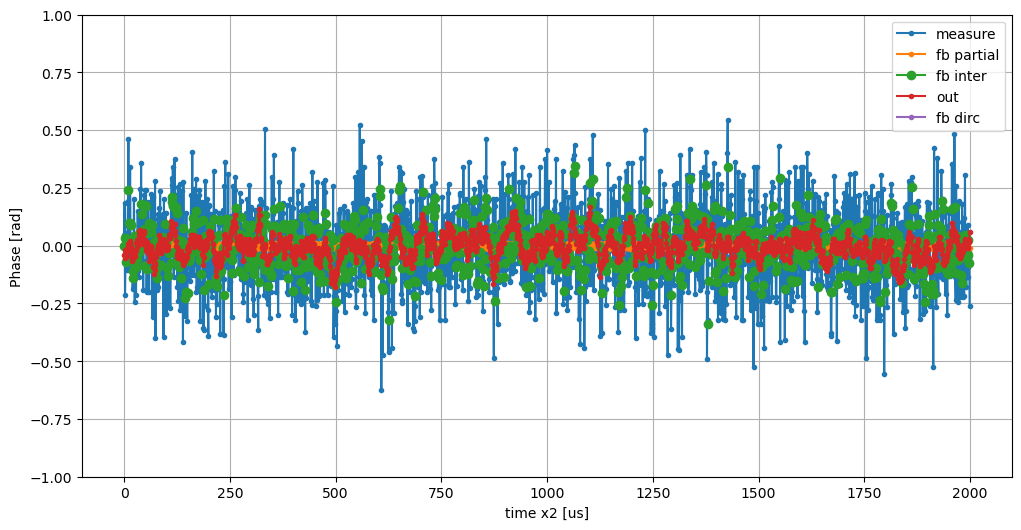

In [174]:
x0=400*5
x1=800*5
plt.figure(figsize=(12,6))
plt.plot(phase_measure_M4[x0:x1],'.-',label='measure')
plt.plot(phase_fb_M4[x0:x1],'.-',label='fb partial')
plt.plot(phase_fb_inter_M4[x0:x1],'o-',label='fb inter')
plt.plot(phase_M4[:,-1].reshape(-1)[x0:x1],'.-',label='out')
plt.plot(phase_fb_dirc_M4[x0:x1],'.-',label='fb dirc')
plt.legend(loc=1)
plt.grid()
plt.xlabel('time x{} [us]'.format(time_exposure))
plt.ylabel('Phase [rad]')
plt.ylim([-1,1])

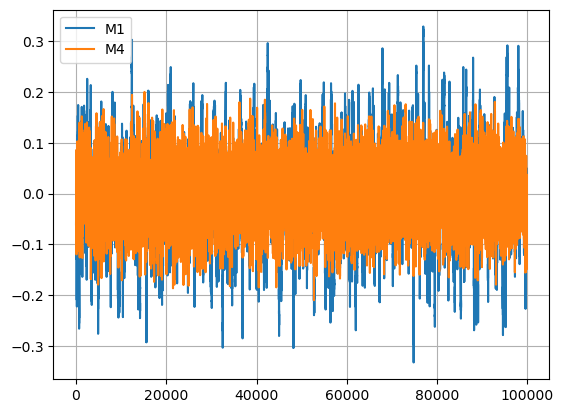

In [175]:
x0=100
x1=100000
plt.plot(phase_out_M1[x0:x1],label='M1')
plt.plot(phase_out_M4[x0:x1],label='M4')
plt.legend()
plt.grid()